In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

import sys
sys.path.append('/home/sol/Escritorio/paper_reservoir/')


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction

In [2]:
GRN_systems = [grn for index, grn in enumerate(grn_networks.grn_names)
                   if grn.lower()=='ecocyc']
graph = grn_networks.load_network(GRN_systems[0])
graph = nt.prune_graph(graph, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [3]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
#SR_scale = 0.9
num_inputs = float('0.99')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = 30
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)

C:\Users\Maria\AppData\Local\Temp\ipykernel_21544\2652215322.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph).todense()


In [4]:
def reservoir_performance(data_source, adj_matrix, input_weight=None,
                          spectral_radius_scale=0.9, with_bias=True):

    if hasattr(adj_matrix, "todense"):
        adj_matrix = adj_matrix.todense()
    adj_matrix = np.asarray(adj_matrix)

    # Generate dataset
    [x, y] = data_source.func(sample_len=1000)
    #print(len(x))

    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)

    if spectral_radius_scale:
        spectral_radius = get_spectral_radius(weights)
        if spectral_radius == 0:
            raise RuntimeError("Nilpotent adjacency matrix matrix")
        weights *= spectral_radius_scale / spectral_radius

    in_scaling = 0.05
    in_weight = input_weight * in_scaling

    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                i_sig.ravel())
                    for i_sig in x]
    rregr = RidgeRegression(use_bias=with_bias)
    [rregr.train(x_train, y_train)
     for x_train, y_train in zip(res_dynamics[:-1], y[:-1])]
    pred = rregr(res_dynamics[-1])
    nrmse_res = nrmse(pred, y[-1])

    if np.isnan(nrmse_res) or np.isinf(nrmse_res):
        raise RuntimeError("The NRMSE value obtained is not finite.")

    return nrmse_res


class _data_source():
    def __init__(self, name, func):
        self.name = name
        self.func = func


data_sources = [_data_source("10th order NARMA", narma10),
                _data_source("30th order NARMA", narma30)]

cp_file_layout = "multy_{task}NARMA_{system}_{num_trials}trials.cp"

In [7]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
for SR_scale in array_SR_values:
    results = []
    while len(results) < num_trials:
        if rand_inputs:
            np.random.shuffle(inputs_arr)
        results.append(reservoir_performance(data_sources[0], adj_matrix,
                                        input_weight=inputs_arr,
                                        spectral_radius_scale=SR_scale))
        print(len(results))
    mem_capac_spectral.append(np.mean(results))
    std_dev_res.append(np.std(results))
    print(len(mem_capac_spectral))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
6
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
7
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
10
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
11
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
12
1

In [13]:
np.savetxt('NARMA_30TRIALS_variedSR.txt', np.c_[array_SR_values,mem_capac_spectral,std_dev_res])   # x,y,z equal sized 1D arrays



In [16]:
std_dev_res

[0.022719759629416914,
 0.01819025757691115,
 0.044335304491352735,
 0.1262161202885601,
 0.053847074771439546,
 0.040834786744396195,
 0.0357298327145237,
 0.02124656171560381,
 0.023259932992913984,
 0.02172795386013832,
 0.034659602510657896,
 0.026466358474035157,
 0.057217391347828134,
 0.4221386943180846,
 0.7168038974931127,
 0.09990734264424118,
 0.1635966039440455,
 0.10695055670309842,
 0.5083583349873868,
 2.034544640729816]

<ErrorbarContainer object of 3 artists>

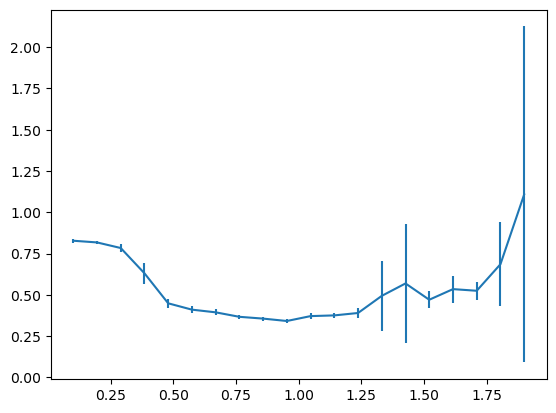

In [11]:
import matplotlib.pyplot as plt 
plt.errorbar(array_SR_values, mem_capac_spectral, yerr=np.array(std_dev_res)/2, label='both limits (default)')
#plt.plot(array_SR_values , mem_capac_spectral)

In [10]:
std_dev_res

[0.022719759629416914,
 0.01819025757691115,
 0.044335304491352735,
 0.1262161202885601,
 0.053847074771439546,
 0.040834786744396195,
 0.0357298327145237,
 0.02124656171560381,
 0.023259932992913984,
 0.02172795386013832,
 0.034659602510657896,
 0.026466358474035157,
 0.057217391347828134,
 0.4221386943180846,
 0.7168038974931127,
 0.09990734264424118,
 0.1635966039440455,
 0.10695055670309842,
 0.5083583349873868,
 2.034544640729816]

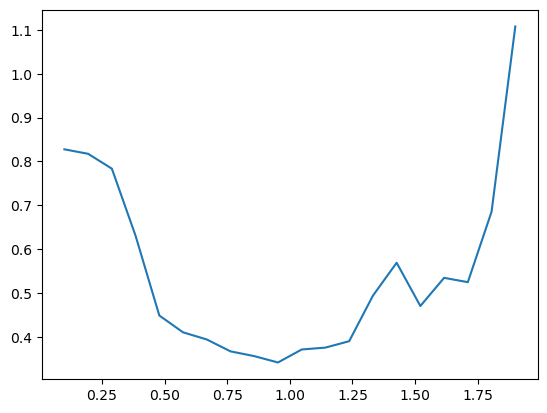

In [9]:
plt.plot(array_SR_values , mem_capac_spectral)

In [5]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)

num_trials = 30
results = np.zeros(20)
all_experiments = []
a = 0


while a < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    mem_capac_spectral = []
    for SR_scale in array_SR_values: 
        mem_capac_spectral.append(reservoir_performance(data_sources[0], adj_matrix,
                                    input_weight=inputs_arr,
                                    spectral_radius_scale=SR_scale))
    results += np.array(mem_capac_spectral)
    all_experiments.append(mem_capac_spectral)
    a+=1
    print(a)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [6]:
desviaciones = []
mean = []
for i in range(len(all_experiments[0])):
    results = []
    for experiment in all_experiments:
        results.append(experiment[i])
    desviaciones.append(np.std(results))
    mean.append(np.mean(results))

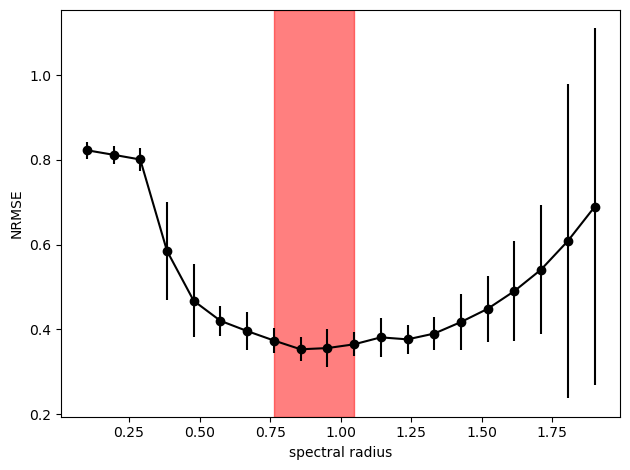

In [25]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()
plt.plot(array_SR_values , mean, "o", color = "k")
plt.errorbar(array_SR_values, mean, yerr=np.array(desviaciones), label='both limits (default)', color = "k")
plt.axvspan(array_SR_values[int(np.argwhere(mean == min(mean)))-1], array_SR_values[int(np.argwhere(mean == min(mean)))+2], alpha=0.5, color='red')
#plt.axhline(y=0)
#plt.axvline(x=0.95)
plt.ylabel("NRMSE")
plt.xlabel("spectral radius")
plt.tight_layout()
plt.show()

In [26]:
np.savetxt('NARMA_30TRIALS_variedSR.txt', np.c_[array_SR_values, mean, desviaciones])   # x,y,z equal sized 1D arrays


In [40]:
np.random.rand(1, 1) * .5

array([[0.02122247]])

# Input scaling

In [4]:
def reservoir_performance(data_source, adj_matrix, input_weight=None,
                          spectral_radius_scale=0.9, with_bias=True, in_scaling= 0.05):

    if hasattr(adj_matrix, "todense"):
        adj_matrix = adj_matrix.todense()
    adj_matrix = np.asarray(adj_matrix)

    # Generate dataset
    [x, y] = data_source.func(sample_len=1000)
    #print(len(x))

    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)

    if spectral_radius_scale:
        spectral_radius = get_spectral_radius(weights)
        if spectral_radius == 0:
            raise RuntimeError("Nilpotent adjacency matrix matrix")
        weights *= spectral_radius_scale / spectral_radius

    #in_scaling = 0.05
    in_weight = input_weight * in_scaling

    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                i_sig.ravel())
                    for i_sig in x]
    rregr = RidgeRegression(use_bias=with_bias)
    [rregr.train(x_train, y_train)
     for x_train, y_train in zip(res_dynamics[:-1], y[:-1])]
    pred = rregr(res_dynamics[-1])
    nrmse_res = nrmse(pred, y[-1])

    if np.isnan(nrmse_res) or np.isinf(nrmse_res):
        raise RuntimeError("The NRMSE value obtained is not finite.")

    return nrmse_res


class _data_source():
    def __init__(self, name, func):
        self.name = name
        self.func = func


data_sources = [_data_source("10th order NARMA", narma10),
                _data_source("30th order NARMA", narma30)]

cp_file_layout = "multy_{task}NARMA_{system}_{num_trials}trials.cp"

In [5]:
array_SR_values = np.linspace(0.01, 1.0, 20)
prngI = np.random.RandomState(42)

num_trials = 30
results = np.zeros(20)
all_experiments = []
a = 0


while a < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    mem_capac_spectral = []
    for SR_scale in array_SR_values: 
        mem_capac_spectral.append(reservoir_performance(data_sources[0], adj_matrix,
                                    input_weight=inputs_arr,
                                    spectral_radius_scale=0.9, in_scaling= SR_scale))
    results += np.array(mem_capac_spectral)
    all_experiments.append(mem_capac_spectral)
    a+=1
    print(a)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [6]:
desviaciones = []
mean = []
for i in range(len(all_experiments[0])):
    results = []
    for experiment in all_experiments:
        results.append(experiment[i])
    desviaciones.append(np.std(results))
    mean.append(np.mean(results))

<ErrorbarContainer object of 3 artists>

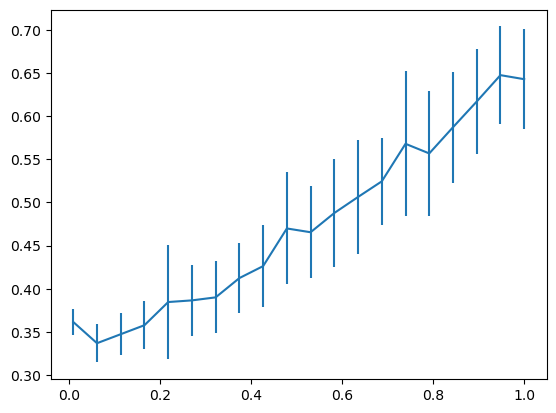

In [7]:
import matplotlib.pyplot as plt 
#plt.plot(array_SR_values , mean)
plt.errorbar(array_SR_values, mean, yerr=np.array(desviaciones), label='both limits (default)')
#plt.axhline(y=0)
#plt.axvline(x=0.95)

In [13]:
np.argwhere(mean==min(mean))

array([[1]])

In [14]:
array_SR_values[1]

0.06210526315789474